In [6]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'

from PIL import Image

import pandas as pd

import re

In [7]:
rooms_set = {"DINING ROOM", "KITCHEN", "LIVING ROOM", 
             "BEDROOM 1", "BEDROOM 2", "BEDROOM 3", 
             "MASTER BEDROOM", "SITTING ROOM"}

In [1]:
rooms_list = ["DINING ROOM", "KITCHEN", "LIVING ROOM", 
             "BEDROOM 1", "BEDROOM 2", "BEDROOM 3", "BEDROOM 4", "GARAGE", 
             "MASTER BEDROOM", "SITTING ROOM", "UTILITY", "CONSERVATORY", "RECEPTION ROOM
              "]

In [49]:
room_sides_regex = re.compile('[0-9][.][0-9][0-9][M]\s[X]\s[0-9][.][0-9][0-9][M]')

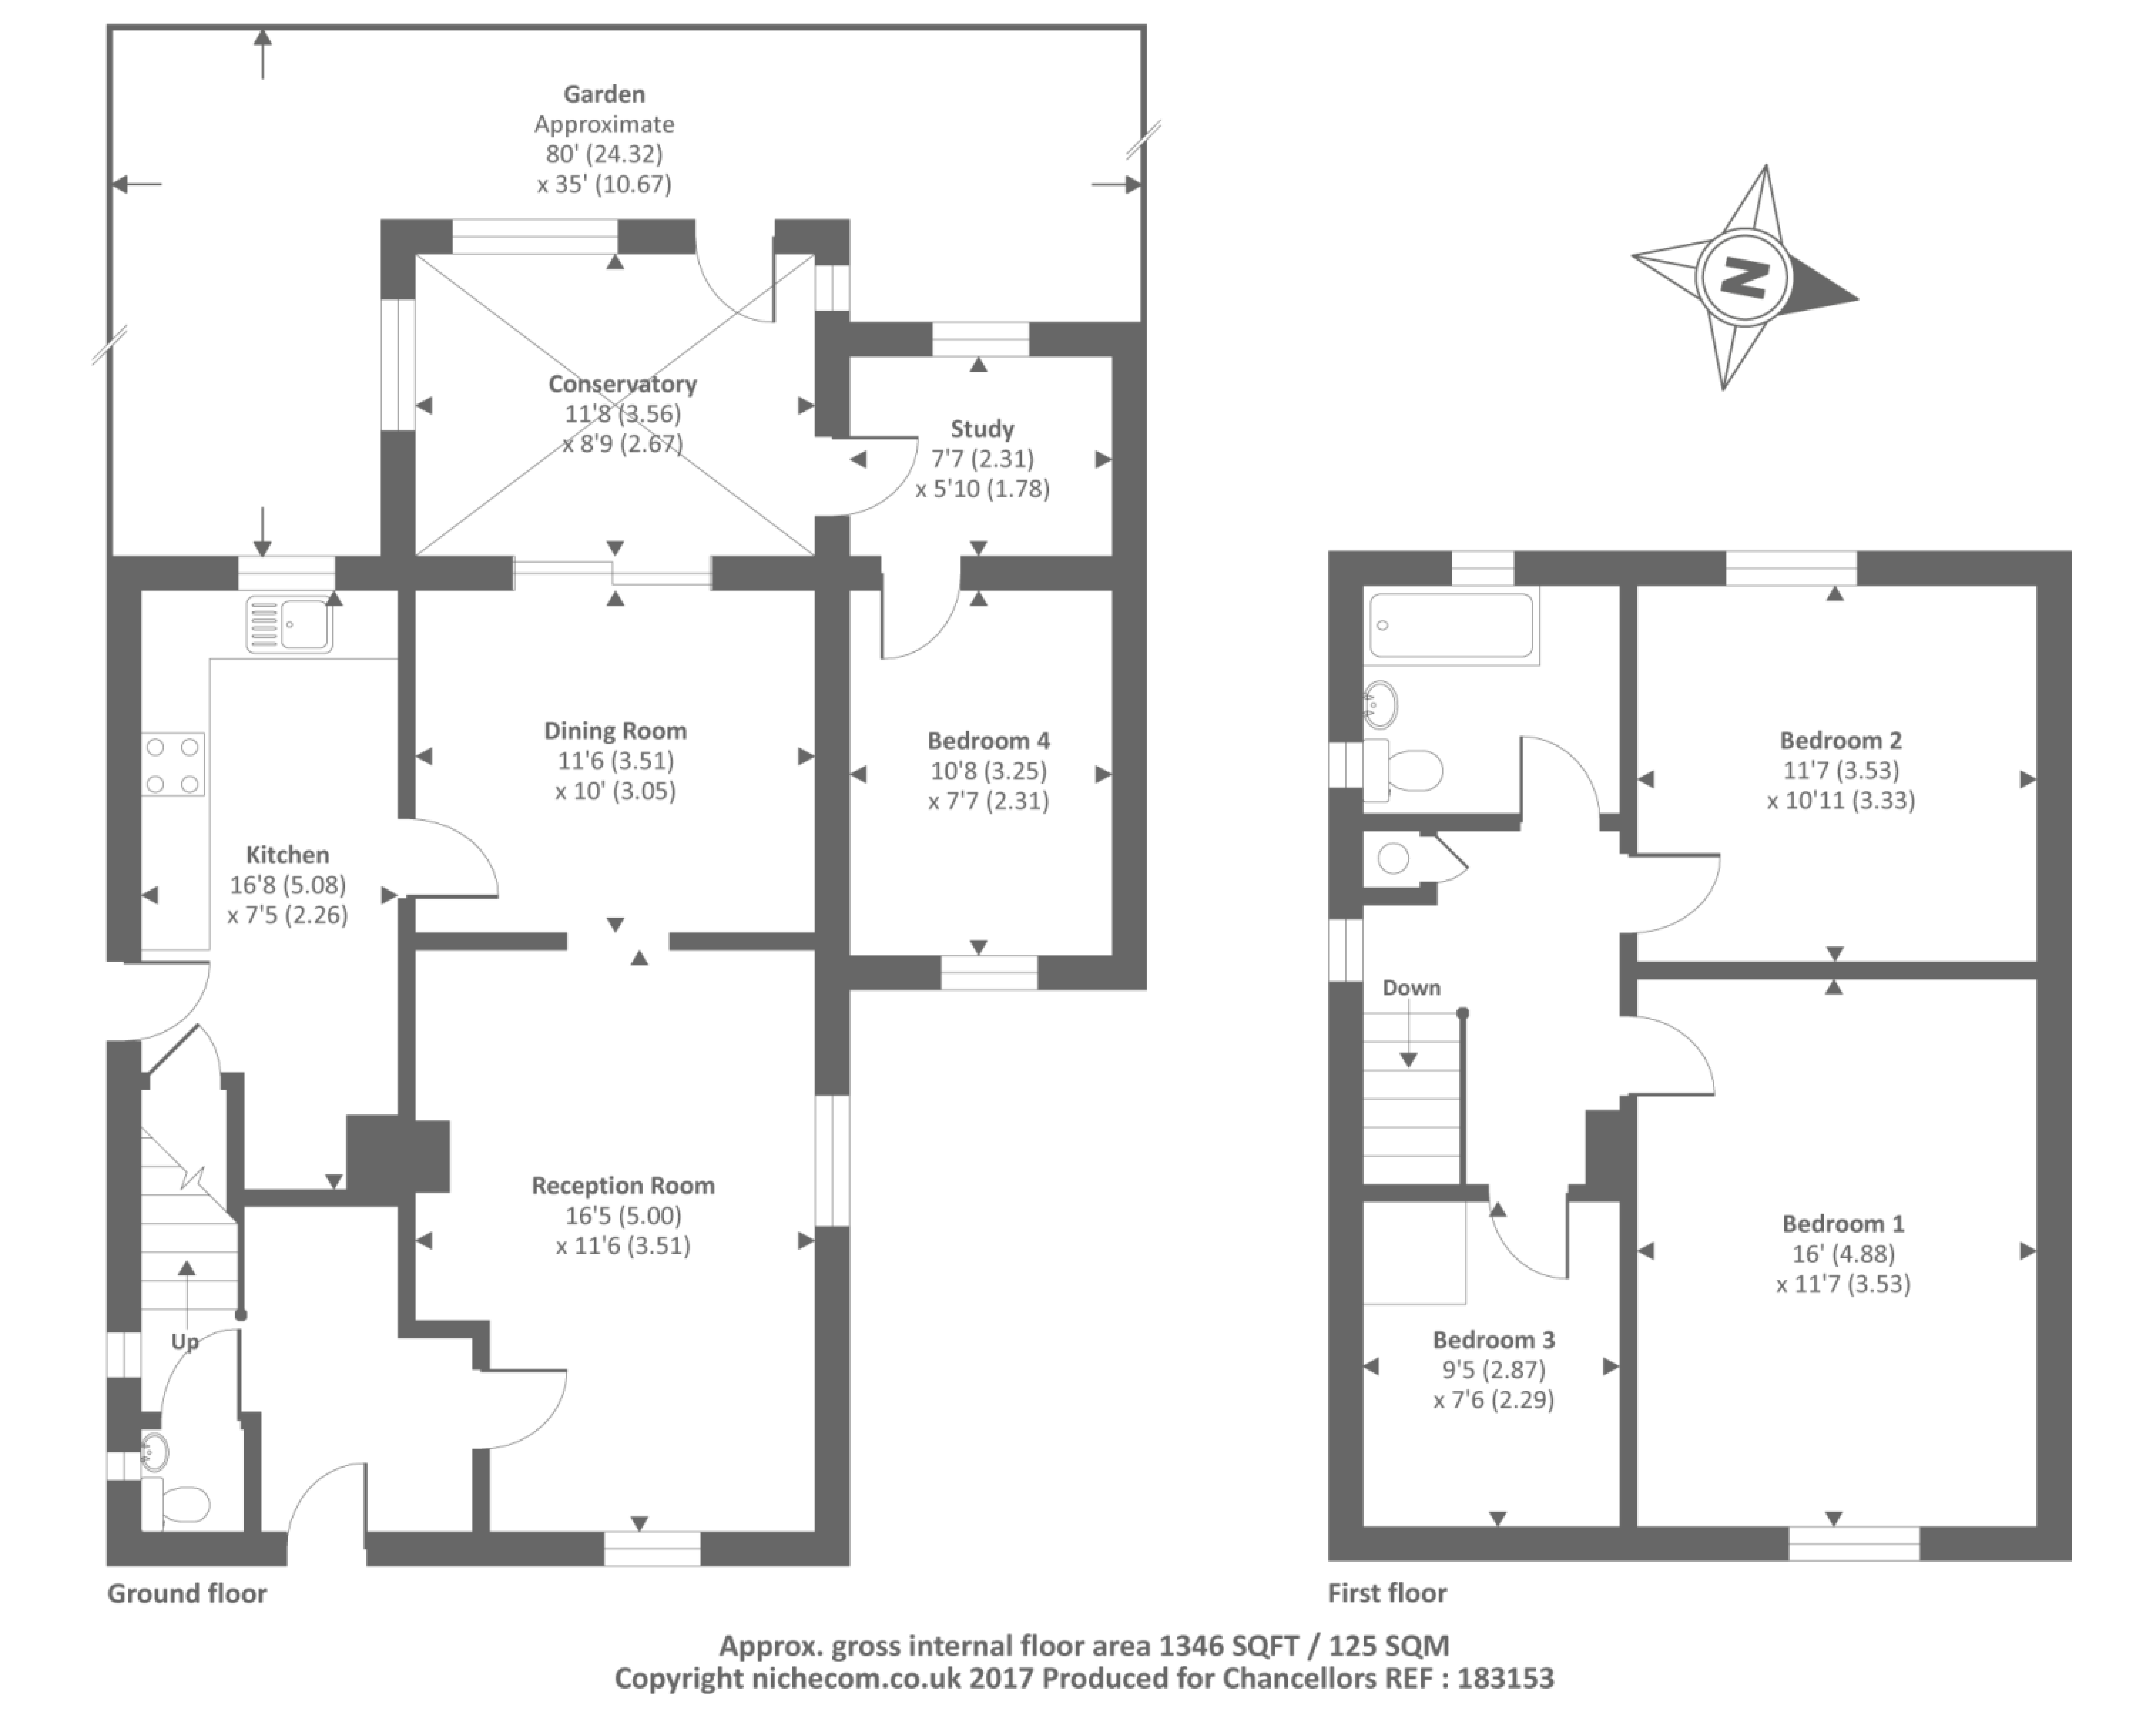

In [22]:
image = Image.open('plans/floorplan_04.png')
image = image.resize((image.size[0] * 5, image.size[1] * 5))
image

In [16]:
floorplan_text = pytesseract.image_to_string(image)
floorplan_text = floorplan_text.upper()
floorplan_text = floorplan_text.strip()
floorplan_text

"GARDEN\nAPPROXIMATE\n80° (24.32)\nX 35' (10.67)\n\n4\n4,\n%,\n\n \n \n    \n  \n   \n\n \n\n   \n \n\n   \n \n    \n\n \n\nCONSERVATORY\n11'8'{3.56) STUDY\nAS 8'9 (2.62) 4 =| 7'7(2.31)\n\nANU\n\n \n\n“\nDINING ROOM BEDROOM 4\n11'6 (3.51) 10'8 (3.25)\nX 10° (3.05) X 7'7 (2.31)\n\nKITCHEN\n168 (5.08)\nX 7'S (2.26)\n\n    \n \n  \n\nRECEPTION ROOM\n16'S (5.00)\nX 11'6 (3.51)\n\n \n\n \n\nGROUND FLOOR\n\n   \n\n \n\n \n\n \n\nBEDROOM 2\n11'7 (3.53)\nX 10'11 (3.33)\n\n \n\nI BEDROOM 1\n\\ 16' (4.88)\nX 11'7 (3.53)\nBEDROOM 3\n9'5 (2.87)\nX 7'6 (2.29)\n¥\n\nFIRST FLOOR\n\nAPPROX. GROSS INTERNAL FLOOR AREA 1346 SQFT / 125 SQM\nCOPYRIGHT NICHECOM.CO.UK 2017 PRODUCED FOR CHANCELLORS REF : 183153"

In [10]:
text = pytesseract.image_to_data(image, output_type='data.frame')
text = text[text.conf != -1]

lines = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['text'] \
                                     .apply(lambda x: ' '.join(list(x))).tolist()
confs = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['conf'].mean().tolist()
    
line_conf = []
    
for i in range(len(lines)):
    if lines[i].strip():
        line_conf.append((lines[i], round(confs[i],3)))

In [11]:
line_conf

[('Garden', 96.0),
 ('Approximate', 96.0),
 ("80' (24.32)", 91.0),
 ("x 35' (10.67)", 89.333),
 ('Conservatory', 19.0),
 ("11''¢3.56)", 0.0),
 ('org 1 Stud', 39.667),
 ('ABS (2.82 « =$/77 (2.31)', 40.2),
 (": - _/ x5'10 (1.78)", 41.2),
 ('Dining Room', 95.5),
 ("11'6 (3.51)", 90.5),
 ("x 10' (3.05)", 90.667),
 ('Bedroom 4', 96.0),
 ("10'8 (3.25)", 91.0),
 ("x 7'7 (2.31)", 75.0),
 ('Kitchen', 96.0),
 ("16'8 (5.08)", 93.5),
 ("x 7'5 (2.26)", 86.0),
 ('Reception Room', 95.0),
 ("16'5 (5.00)", 92.5),
 ("x 11'6 (3.51)", 91.667),
 ('Ground floor', 95.5),
 ('Bedroom 2', 95.0),
 ("11'7 (3.53)", 93.5),
 ("x 10'11 (3.33)", 91.333),
 ('Bedroom 1', 95.0),
 ("16' (4.88)", 92.5),
 ("x 11'7 (3.53)", 88.667),
 ('Bedroom 3', 95.0),
 ("9'5 (2.87)", 94.0),
 ("x 7'6 (2.29)", 85.333),
 ('First floor', 96.0),
 ('Approx. gross internal floor area 1346 SQFT / 125 SQM', 94.8),
 ('Copyright nichecom.co.uk 2017 Produced for Chancellors REF : 183153',
  94.333)]

In [52]:
room = []
side_a = []
side_b = []
size = []

# first, we search for all the rooms, arrange them in order

rooms_positions_list = []

for i in range(len(rooms_list)):
    curr_pos = floorplan_text.find(rooms_list[i])
    rooms_positions_list.append(curr_pos)
    
rooms_order = pd.DataFrame(columns = ['room', 'position'])
rooms_order['room'] = rooms_list
rooms_order['position'] = rooms_positions_list

rooms_order = rooms_order[rooms_order['position'] > -1]
rooms_order = rooms_order.sort_values(by = 'position')

room = list(rooms_order['room'])

for curr_room in room:
    position = floorplan_text.find(curr_room)
    # removes the room from the text
    floorplan_text = floorplan_text[:position] + floorplan_text[position + len(curr_room):]
    # find the next m pair
    room_sides_search = room_sides_regex.search(floorplan_text[position:])
    curr_side_a = float(room_sides_search.group()[:4])
    curr_side_b = float(room_sides_search.group()[8:-1])
    side_a.append(curr_side_a)
    side_b.append(curr_side_b)
    size.append(round(curr_side_a * curr_side_b,2))
    # removes the sides from the text
    floorplan_text = floorplan_text[:position + room_sides_search.span()[0]] + \
        floorplan_text[position + room_sides_search.span()[1]:]


In [53]:
room

['UTILITY',
 'GARAGE',
 'KITCHEN',
 'SITTING ROOM',
 'BEDROOM 1',
 'BEDROOM 2',
 'BEDROOM 4',
 'BEDROOM 3']

In [54]:
side_a

[2.51, 3.88, 6.3, 7.01, 3.1, 3.1, 3.66, 3.23]

In [1]:
import floorplan_reader_01

In [10]:
table = floorplan_reader_01.convert_floorplan_string_to_table('plans/floorplan_02.png', rooms_set)
table

,side_a,side_b,size
SITTING ROOM,3.69,4.74,17.49
MASTER BEDROOM,2.47,3.66,9.04
BEDROOM 2,2.17,2.56,5.56
KITCHEN,4.74,3.55,16.83


In [7]:
import floorplan_reader_02

In [9]:
table = floorplan_reader_02.convert_floorplan_string_to_table('plans/floorplan_02.png', rooms_set)
table

,side_a,side_b,size
BEDROOM 3,2.17,2.56,5.56
SITTING ROOM,3.69,4.74,17.49
MASTER BEDROOM,4.74,3.55,16.83
BEDROOM 2,2.47,3.66,9.04
KITCHEN,3.14,2.95,9.26


In [20]:
import floorplan_reader_03

In [21]:
table = floorplan_reader_03.convert_floorplan_string_to_table('plans/floorplan_02.png', rooms_list)
table

,side_a,side_b,size
KITCHEN,4.74,3.55,16.83
MASTER BEDROOM,3.14,2.95,9.26
SITTING ROOM,3.69,4.74,17.49
BEDROOM 2,2.47,3.66,9.04
BEDROOM 3,2.17,2.56,5.56


In [3]:
import floorplan_reader_04

In [4]:
table = floorplan_reader_04.convert_floorplan_string_to_table('plans/floorplan_03.jpeg', rooms_list)
table

,side_a,side_b,size
UTILITY,2.51,2.44,6.12
GARAGE,3.88,2.57,9.97
KITCHEN,6.30,3.61,22.74
SITTING ROOM,7.01,3.66,25.66
BEDROOM 1,3.10,3.00,9.30
BEDROOM 2,3.10,3.05,9.46
BEDROOM 4,3.66,2.98,10.91
BEDROOM 3,3.23,2.92,9.43
